In [133]:
from IPython.core.display import display, HTML, Javascript

# ----- Notebook Theme -----
color_map = ['#16a085', '#e8f6f3', '#d0ece7', '#a2d9ce', '#73c6b6', '#45b39d', 
                        '#16a085', '#138d75', '#117a65', '#0e6655', '#0b5345']

prompt = color_map[-1]
main_color = color_map[0]
strong_main_color = color_map[1]
custom_colors = [strong_main_color, main_color]

css_file = ''' 

div #notebook {
background-color: white;
line-height: 20px;
}

#notebook-container {
%s
margin-top: 2em;
padding-top: 2em;
border-top: 4px solid %s; /* light orange */
-webkit-box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
    box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
}

div .input {
margin-bottom: 1em;
}

.rendered_html h1, .rendered_html h2, .rendered_html h3, .rendered_html h4, .rendered_html h5, .rendered_html h6 {
color: %s; /* light orange */
font-weight: 600;
}

div.input_area {
border: none;
    background-color: %s; /* rgba(229, 143, 101, 0.1); light orange [exactly #E58F65] */
    border-top: 2px solid %s; /* light orange */
}

div.input_prompt {
color: %s; /* light blue */
}

div.output_prompt {
color: %s; /* strong orange */
}

div.cell.selected:before, div.cell.selected.jupyter-soft-selected:before {
background: %s; /* light orange */
}

div.cell.selected, div.cell.selected.jupyter-soft-selected {
    border-color: %s; /* light orange */
}

.edit_mode div.cell.selected:before {
background: %s; /* light orange */
}

.edit_mode div.cell.selected {
border-color: %s; /* light orange */

}
'''
def to_rgb(h): 
    return tuple(int(h[i:i+2], 16) for i in [0, 2, 4])

main_color_rgba = 'rgba(%s, %s, %s, 0.1)' % (to_rgb(main_color[1:]))
open('notebook.css', 'w').write(css_file % ('width: 95%;', main_color, main_color, main_color_rgba, main_color,  main_color, prompt, main_color, main_color, main_color, main_color))

def nb(): 
    return HTML("<style>" + open("notebook.css", "r").read() + "</style>")
nb()

C:\Users\kot\AppData\Local\Temp\ipykernel_36104\1016028258.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Javascript


<img src="https://github.com/AILab-MLTools/LightAutoML/raw/master/imgs/LightAutoML_logo_big.png" alt="LightAutoML logo" style="width:70%;"/>

# LightAutoML baseline

Official LightAutoML github repository is [here](https://github.com/AILab-MLTools/LightAutoML). 

### Do not forget to put upvote for the notebook, follow me on Kaggle and the ⭐️ for github repo if you like it - one click for you, great pleasure for us ☺️ 
### If you miss the [simple baseline notebook](https://www.kaggle.com/code/alexryzhkov/clone-my-notebook) for this competition, please take a look and upvote it as well. 

In [134]:
s = '<iframe src="https://ghbtns.com/github-btn.html?user=sb-ai-lab&repo=LightAutoML&type=star&count=true&size=large" frameborder="0" scrolling="0" width="170" height="30" title="LightAutoML GitHub"></iframe>'
HTML(s)

c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\IPython\core\display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## This notebook is the updated copy of our [Tutorial_1 from the GIT repository](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb). Please check our [tutorials folder](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials) if you are interested in other examples of LightAutoML functionality.

## 0. Prerequisites

### 0.0. install LightAutoML

In [135]:
%%capture
!pip install lightautoml

# QUICK WORKAROUND FOR PROBLEM WITH PANDAS
!pip install -U pandas

### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: `TabularAutoML` preset for AutoML model creation and Task class to setup what kind of ML problem we solve (binary/multiclass classification or regression)

In [136]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

import matplotlib.pyplot as plt
import seaborn as sns

### 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [137]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 900 # equal to 15 minutes
TARGET_NAME = 'final_price'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [138]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [139]:
INPUT_DIR = 'data/'

In [140]:
train_data = pd.read_csv(INPUT_DIR + 'train_data.csv')
print(train_data.shape)
train_data.head()

(35000, 15)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0


In [141]:
display(train_data.info())
display(train_data['vehicle_manufacturer'].value_counts())
display(len(train_data['vehicle_manufacturer'].unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  35000 non-null  int64  
 1   vehicle_manufacturer    34999 non-null  object 
 2   vehicle_model           34993 non-null  object 
 3   vehicle_category        34999 non-null  object 
 4   current_mileage         35000 non-null  int64  
 5   vehicle_year            35000 non-null  int64  
 6   vehicle_gearbox_type    34999 non-null  object 
 7   doors_cnt               34255 non-null  object 
 8   wheels                  34999 non-null  object 
 9   vehicle_color           34599 non-null  object 
 10  vehicle_interior_color  28282 non-null  object 
 11  car_vin                 11488 non-null  object 
 12  car_leather_interior    35000 non-null  int64  
 13  deal_type               35000 non-null  object 
 14  final_price             35000 non-null

None

TOYOTA           6768
HYUNDAI          6286
MERCEDES-BENZ    4022
FORD             2269
LEXUS            1776
                 ... 
MG                  1
JAC                 1
TATA                1
LANCIA              1
LAMBORGHINI         1
Name: vehicle_manufacturer, Length: 68, dtype: int64

69

In [142]:
test_data = pd.read_csv(INPUT_DIR + 'test_data.csv')
print(test_data.shape)
test_data.head()

(10697, 14)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type
0,35000,TOYOTA,Prius,Hatchback,323733,2012,Automatic,4/5,Left wheel,Grey,Black,JTDKN3DU6C5439638,1,For Sale
1,35001,HYUNDAI,Elantra,Sedan,112000,2013,Tiptronic,4/5,Left wheel,Grey,Black,SURATSHIA,1,For Sale
2,35002,LEXUS,NX 300,Jeep,16920,2018,Automatic,NaN,Left wheel,Brown,NaN,JTJYARBZ5J2104521,1,For Sale
3,35003,LEXUS,CT 200h,Hatchback,302742,2012,Automatic,4/5,Left wheel,White,NaN,JTHKD5BH4C2070945,1,For Sale
4,35004,TOYOTA,RAV 4,Jeep,1800,2002,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale


In [143]:
display(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10697 entries, 0 to 10696
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   row_ID                  10697 non-null  int64 
 1   vehicle_manufacturer    10696 non-null  object
 2   vehicle_model           10695 non-null  object
 3   vehicle_category        10696 non-null  object
 4   current_mileage         10697 non-null  int64 
 5   vehicle_year            10697 non-null  int64 
 6   vehicle_gearbox_type    10696 non-null  object
 7   doors_cnt               10474 non-null  object
 8   wheels                  10696 non-null  object
 9   vehicle_color           10563 non-null  object
 10  vehicle_interior_color  8619 non-null   object
 11  car_vin                 3566 non-null   object
 12  car_leather_interior    10697 non-null  int64 
 13  deal_type               10697 non-null  object
dtypes: int64(4), object(10)
memory usage: 1.1+ MB


None

In [144]:
submission = pd.read_csv(INPUT_DIR + 'sample_submission.csv')
print(submission.shape)
submission.head()

(10697, 2)


,row_ID,final_price
0,35000,0
1,35001,0
2,35002,0
3,35003,0
4,35004,0


### Step 0.5. Some user feature preparation

Be creative :)

In [145]:
def create_expert_feats(data, drop_columns):
    """Функция осуществляет поиск признаков, в которых количество 
    пропусков менее 5% и заменяет их на самое часто встречающееся 
    значение. Затем создает признак 'duplicates', в котором оставляет 
    пометку о дублировании записи.

    Args:
        data (DataFrame): DataFrame, в котором необходмо выполнить 
        обработку данных
        drop_columns (str, list): Название признака, который следует 
        изключить при поиске дубликатов

    Returns:
        DataFrame: Возвращает DataFrame с заполненными пропусками и 
        пометкой о наличии дубликатов
    """
    null_cols_before = round(data.isnull().mean() * 100, 3)
    print('Количество пропусков до преобразования:')
    display(null_cols_before[null_cols_before > 0])
    
    # Подсчет процента пропусков в столбцах
    cols_null_percent = data.isnull().mean() * 100

    # Выбираем столбцы, с количеством пропусков менее 5%
    cols_with_null = cols_null_percent[(cols_null_percent > 0) & (cols_null_percent < 5)].round(3)

    # Заполнение отсутсвующих данных самым распространенным значением
    for col in cols_with_null.index:
        data[col] = data[col].fillna(data[col].mode()[0])
    
    
    null_cols_after = round(data.isnull().mean() * 100, 3)
    print('Количество пропусков после преобразования:')
    display(null_cols_after[null_cols_after > 0])
    
    # Определение количества дубликатов
    dupl_columns = list(data.columns)
    dupl_columns.remove(drop_columns)

    mask = data.duplicated(subset=dupl_columns)
    data_duplicates = data[mask]
    print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')
    
    # Создание признака с пометкой о дублировании записи
    data['duplicates'] = data.duplicated(subset=dupl_columns)
    
    return data


def data_visualization(data, feature, title=''):
    """Функция по построению Гистограммы и Коробчатой диаграммы

    Args:
        data (DataFrame): Набор данных
        feature (str): Признак, по которому необходимо построить графики
        title (str, optional): Название графика. По умолчанию ''.
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 3))
    histplot = sns.histplot(data=data, x=feature, bins=40, ax=axes[0])
    histplot.set_title(title)
    boxplot = sns.boxplot(data=data, x=feature, width=0.5, ax=axes[1])
    boxplot.set_title(title);


def outliers_iqr(data, feature, left=1.5, right=1.5):
    """Функция реализует алгоритм метода межквартильного размаха для 
       поиска выбросов в данных

    Args:
        data (dataframe): DataFrame с данными
        feature (str): Наименование признака
        left (float, optional): Левая граница. По умолчанию - 1.5.
        right (float, optional): Правая граница. По умолчанию - 1.5.

    Returns:
        outliers (int): Число выбросов
        cleaned (int): Результирующее число записей
    """
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [146]:
all = train_data['final_price'].describe()
sale = train_data[train_data['deal_type'] == 'For Sale']['final_price'].describe()
rent = train_data[train_data['deal_type'] == 'For Rent']['final_price'].describe()

display(pd.DataFrame(dict(all = all, sale = sale, rent = rent)))

,all,sale,rent
count,3.500000e+04,3.437200e+04,628.000000
mean,6.014077e+03,6.119695e+03,233.326433
std,7.341517e+04,7.407840e+04,1370.949632
min,0.000000e+00,0.000000e+00,0.000000
25%,1.350000e+03,1.500000e+03,13.000000
50%,3.900000e+03,4.000000e+03,16.000000
75%,7.000000e+03,7.000000e+03,32.000000
max,8.388607e+06,8.388607e+06,19000.000000


### Check for price anamolies
let's inspect the dataset and find the peaks and unusual prices. First sort the prices and show Top20. Then group the data by prices and find how many entries we can remove on the lower end 


Max Values of Price:



32442    8388607.0
3877     8388607.0
34052    6666666.0
12136    1111111.0
24980    1111111.0
15291     200000.0
19820     135000.0
32937     135000.0
20577     111111.0
26879      98500.0
14727      95000.0
5339       92000.0
29612      91000.0
12529      91000.0
19425      90000.0
29967      81000.0
24965      80000.0
10105      79500.0
17923      79000.0
24852      78500.0
Name: final_price, dtype: float64


Count Min Values of Price (by groups of values):



final_price
0.0      2
1.0     25
2.0      8
3.0      3
4.0      2
5.0      2
6.0      3
8.0      2
9.0      3
10.0    29
11.0     5
13.0     2
15.0    24
16.0     3
20.0    29
Name: final_price, dtype: int64

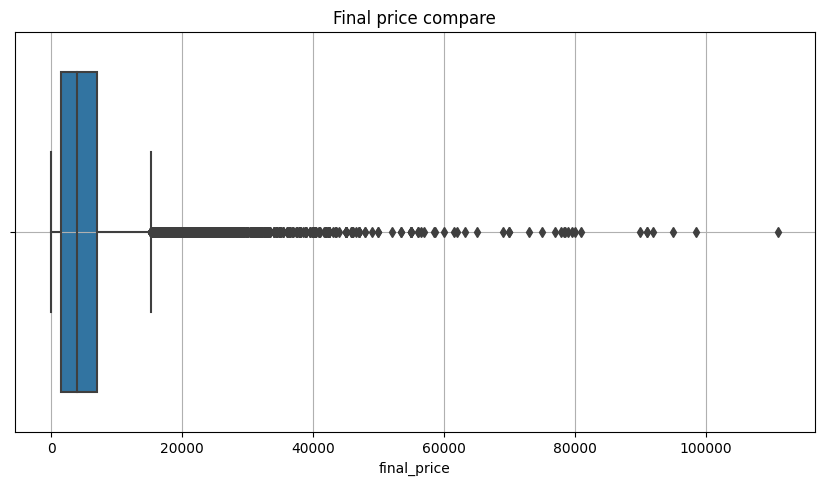

In [147]:
#display(train_data[(train_data['final_price'] > 1000000) & (train_data['final_price'] > 10)])

sort_price = train_data['final_price'].sort_values(ascending=False)
print('\nMax Values of Price:\n')
display(sort_price[:20])

pivot_price = train_data[train_data['deal_type'] == 'For Sale'].groupby('final_price')['final_price'].count()
print('\nCount Min Values of Price (by groups of values):\n')
display(pivot_price[:20])

train_data = train_data.drop(train_data[(train_data['final_price'] > 111111) | (train_data['final_price'] <= 20)].index)

# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для final_price 
sns.boxplot(data=train_data, x='final_price', ax=ax) 
# задаём подпись к графику
ax.set_title('Final price compare')
# задаём отображение сетки
ax.grid();

### Check for milege anomalies
check the anomolies in milage, grouped by milage. We can remove all anamolies

In [148]:
li = [1,2,3,4,5,6,7,8,9,10]
print(li[-3:-5:-1])

[8, 7]


count    3.449000e+04
mean     1.897271e+06
std      5.574189e+07
min      0.000000e+00
25%      7.147900e+04
50%      1.290000e+05
75%      1.900000e+05
max      2.147484e+09
Name: current_mileage, dtype: float64


Count Max Values of Mileage (by groups of values):



current_mileage
2147483647    19
1777777778     1
1390000000     1
1234567899     1
1111111111     4
1000000000     1
999999999      5
866656666      1
666666666      1
558212145      1
536688566      1
333333333      1
222222222      2
128456656      1
123456789      1
111111111      3
100400000      1
58764542       1
55556665       1
Name: current_mileage, dtype: int64

current_mileage
2147483647    19
1777777778     1
1390000000     1
1234567899     1
1111111111     4
1000000000     1
999999999      5
866656666      1
666666666      1
558212145      1
Name: current_mileage, dtype: int64

current_mileage
12648846    1
11200000    1
11111111    7
9999999     1
9497284     1
8558222     1
8400000     1
7789999     1
7563145     1
6768388     1
Name: current_mileage, dtype: int64

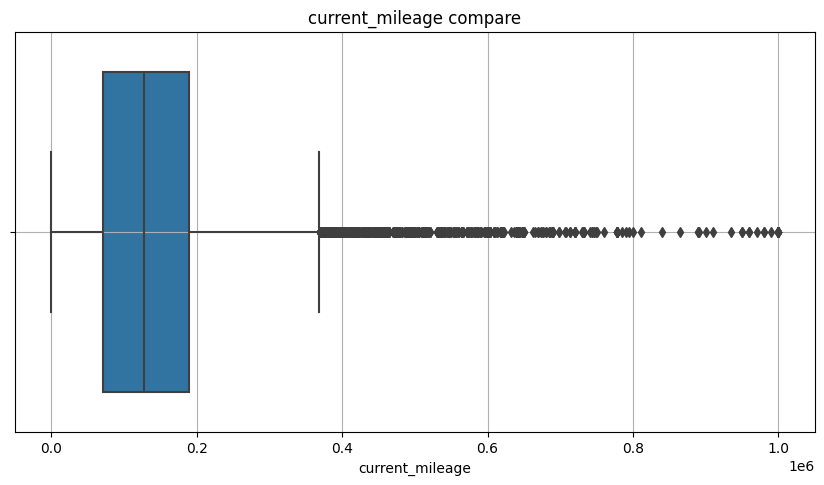

In [149]:
display(train_data['current_mileage'].describe())

print('\nCount Max Values of Mileage (by groups of values):\n')
sort_mileage = train_data.groupby('current_mileage')['current_mileage'].count()

display(sort_mileage[:-20:-1])

display(sort_mileage[:-11:-1])
display(sort_mileage[-31:-41:-1])

train_data = train_data.drop(train_data[(train_data['current_mileage'] > 1000000)].index)

# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для final_price 
sns.boxplot(data=train_data, x='current_mileage', ax=ax) 
# задаём подпись к графику
ax.set_title('current_mileage compare')
# задаём отображение сетки
ax.grid();

Число выбросов по методу Тьюки: 1285
Результирующее число записей: 33052


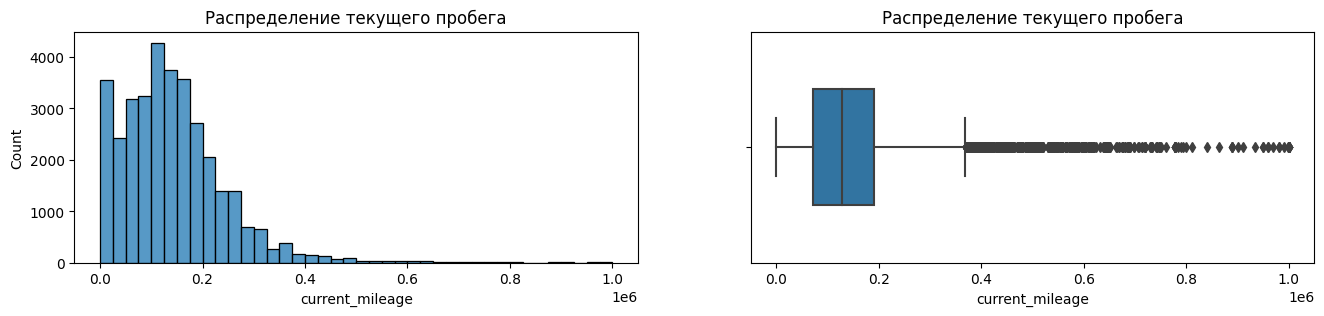

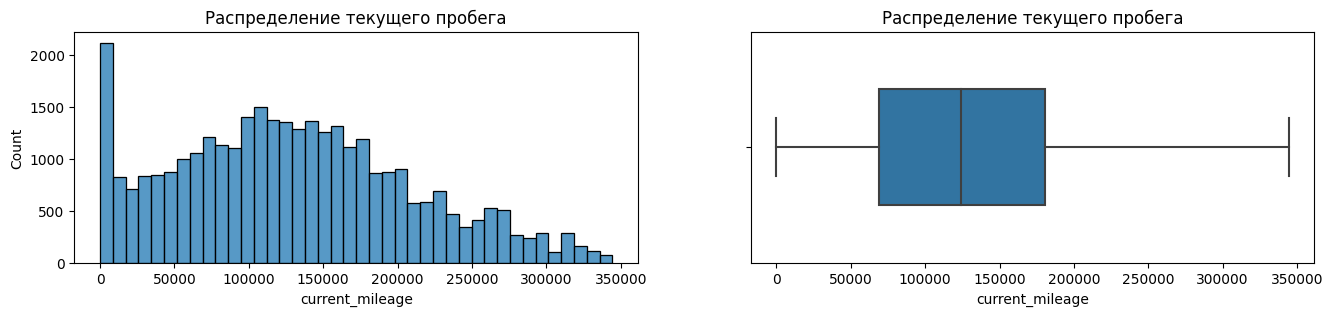

In [150]:
data_visualization(train_data, 'current_mileage', 'Распределение текущего пробега')
train_outliers, train_cleaned = outliers_iqr(train_data, 'current_mileage', right=1.3)

print(f'Число выбросов по методу Тьюки: {train_outliers.shape[0]}')
print(f'Результирующее число записей: {train_cleaned.shape[0]}')

data_visualization(train_cleaned, 'current_mileage', 'Распределение текущего пробега')

### Year
We need to check if any oldtimers can skew the statistic. we can say the oldtimer is the car older then 50 years. we can decide to remove the old cars which soctst more then 5000 if they cost more then 5000 and remove the card older then 30 if they cost more then 10000



The cost of the oldest cars:



,vehicle_year,final_price
23708,1939,50.0
17645,1939,50.0
29082,1939,50.0
32460,1939,64.0
30042,1940,65000.0
9287,1941,15500.0
21930,1943,38000.0
2529,1943,38000.0
3002,1947,64.0
9049,1951,17000.0



The cost of the old cars is more than 10000:



,vehicle_year,final_price
2529,1943,38000.0
9049,1951,17000.0
9287,1941,15500.0
12445,1965,20500.0
14520,1968,8900.0
15402,1953,16500.0
18577,1965,12500.0
20124,1965,21000.0
21930,1943,38000.0
29279,1967,5300.0



Most resent year: 2020


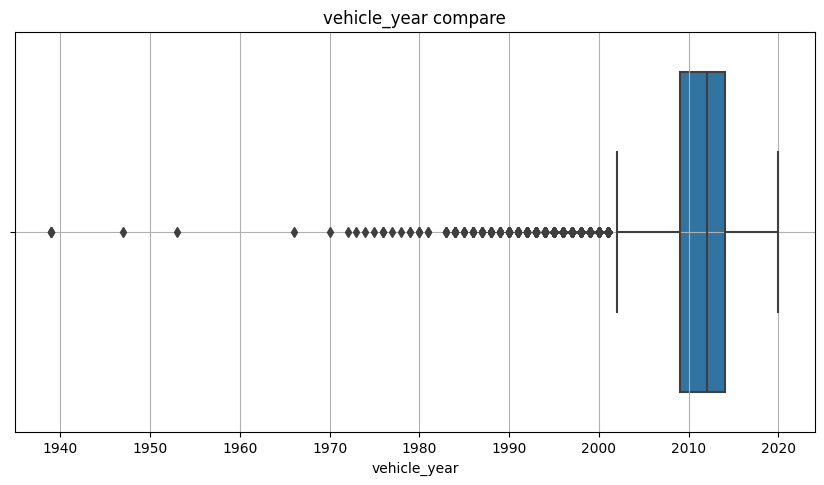

In [151]:
print('\nThe cost of the oldest cars:\n')
display(train_data.sort_values(by='vehicle_year')[['vehicle_year', 'final_price']][:20])

print('\nThe cost of the old cars is more than 10000:\n')
display(train_data[(train_data['vehicle_year'] < 1970) & (train_data['final_price'] >= 5000)][['vehicle_year', 'final_price']][:20])


print('\nMost resent year: {}'.format(train_data['vehicle_year'].max()))

train_data = train_data.drop(train_data[(train_data['vehicle_year'] < 1970) & (train_data['final_price'] >= 1000)].index)
train_data = train_data.drop(train_data[(train_data['vehicle_year'] < 1990) & (train_data['final_price'] >= 5000)].index)

# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для final_price 
sns.boxplot(data=train_data, x='vehicle_year', ax=ax) 
# задаём подпись к графику
ax.set_title('vehicle_year compare')
# задаём отображение сетки
ax.grid();


In [152]:
%%time

def create_expert_feats(data):
    # заменяем колонку года производства машины на колонку возраста машины
    data['car_age'] = 2023 - data['vehicle_year']
    data = data.drop('vehicle_year', axis=1)
    
    return data

create_expert_feats(train_data)
create_expert_feats(test_data)


CPU times: total: 15.6 ms
Wall time: 4.89 ms


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,car_age
0,35000,TOYOTA,Prius,Hatchback,323733,Automatic,4/5,Left wheel,Grey,Black,JTDKN3DU6C5439638,1,For Sale,11
1,35001,HYUNDAI,Elantra,Sedan,112000,Tiptronic,4/5,Left wheel,Grey,Black,SURATSHIA,1,For Sale,10
2,35002,LEXUS,NX 300,Jeep,16920,Automatic,NaN,Left wheel,Brown,NaN,JTJYARBZ5J2104521,1,For Sale,5
3,35003,LEXUS,CT 200h,Hatchback,302742,Automatic,4/5,Left wheel,White,NaN,JTHKD5BH4C2070945,1,For Sale,11
4,35004,TOYOTA,RAV 4,Jeep,1800,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10692,45692,INFINITI,EX30,Jeep,319650,Automatic,NaN,Left wheel,Blue,NaN,JN1AJ0HR9AM751454,1,For Sale,13
10693,45693,MERCEDES-BENZ,E 350,Sedan,107800,Automatic,4/5,Left wheel,Grey,NaN,WDDHF5KB8DA732315,1,For Sale,10
10694,45694,LAND ROVER,Land Rover Sport,Jeep,150000,Tiptronic,4/5,Left wheel,Black,Beige,NaN,1,For Sale,12
10695,45695,TOYOTA,Prius,Hatchback,150000,Variator,4/5,Left wheel,Silver,White,NaN,0,For Sale,13


In [153]:
display(train_data.head())
display(test_data.head())

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,car_age
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0,9
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0,13
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0,7
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0,8
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0,4


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,car_age
0,35000,TOYOTA,Prius,Hatchback,323733,2012,Automatic,4/5,Left wheel,Grey,Black,JTDKN3DU6C5439638,1,For Sale,11
1,35001,HYUNDAI,Elantra,Sedan,112000,2013,Tiptronic,4/5,Left wheel,Grey,Black,SURATSHIA,1,For Sale,10
2,35002,LEXUS,NX 300,Jeep,16920,2018,Automatic,NaN,Left wheel,Brown,NaN,JTJYARBZ5J2104521,1,For Sale,5
3,35003,LEXUS,CT 200h,Hatchback,302742,2012,Automatic,4/5,Left wheel,White,NaN,JTHKD5BH4C2070945,1,For Sale,11
4,35004,TOYOTA,RAV 4,Jeep,1800,2002,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,21


### Rent
remove the rent card from the dataset

Modal rent: 26.0
[21.0, 21.0, 21.0, 21.0, 21.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 24.0, 25.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 35.0, 35.0, 35.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 38.0, 40.0, 40.0, 40.0, 41.0

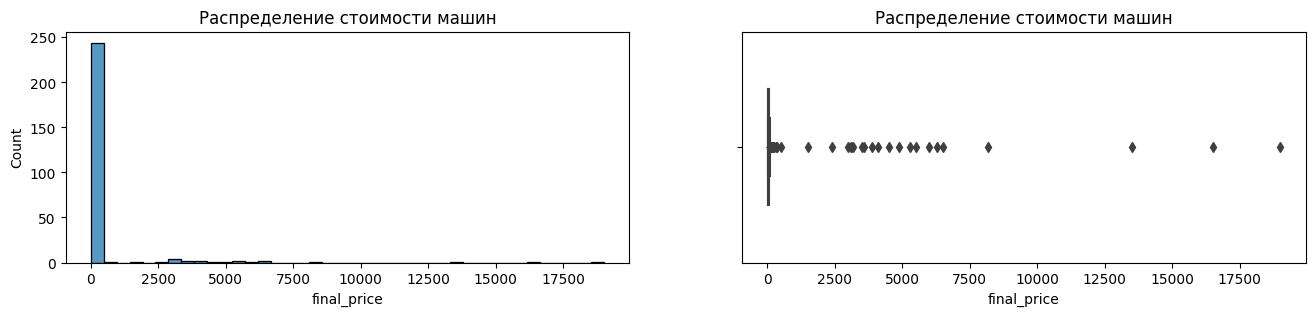

In [158]:
train_data_rent = train_data[train_data["deal_type"] == 'For Rent']

data_visualization(train_data_rent, 'final_price', 'Распределение стоимости машин')

rent_price = train_data_rent['final_price'].mode()[0]
print("Modal rent:", rent_price)

print(list(train_data[train_data["deal_type"] == 'For Rent']["final_price"].sort_values()))



In [160]:
train_data = train_data[train_data['deal_type'] == 'For Sale']
test_data_rent_index = list(test_data[test_data['deal_type'] == 'For Rent'].index)

### 0.6. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [161]:
tr_data, te_data = train_test_split(
    train_data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (27226, 16), te_data = (6807, 16)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,car_age
382,382,HYUNDAI,Santa FE,Jeep,145339,2016,Automatic,4/5,Left wheel,Black,Black,NaN,1,For Sale,13250.0,7
30073,30073,TOYOTA,Prius C,Hatchback,0,2013,Variator,4/5,Left wheel,Grey,Black,NaN,0,For Sale,3270.0,10
21137,21137,BMW,X5,Jeep,180000,2008,Tiptronic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,7500.0,15
25106,25106,TOYOTA,Prius,Hatchback,246480,2011,Automatic,4/5,Left wheel,Grey,NaN,JTDKN3DU9B1468735,1,For Sale,325.0,12
6195,6195,TOYOTA,Camry,Sedan,398069,2014,Automatic,4/5,Left wheel,Black,Black,4T1BF1FK5EU737910,1,For Sale,350.0,9


# 1. Task definition

### 1.1. Task type

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [162]:
task = Task('reg', loss = 'mae', metric = 'mae')

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [163]:
roles = {
    'target': TARGET_NAME,
    'drop': ['row_ID']
}

### 1.3. LightAutoML model creation - TabularAutoML preset

In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

<img src="https://github.com/AILab-MLTools/LightAutoML/raw/master/imgs/tutorial_blackbox_pipeline.png" alt="TabularAutoML preset pipeline" style="width:85%;"/>

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/AILab-MLTools/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we can use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one (more details in [this tutorial](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb))

In [164]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

# 2. AutoML training

To run autoML training use fit_predict method:
- `train_data` - Dataset to train.
- `roles` - Roles dict.
- `verbose` - Controls the verbosity: the higher, the more messages.
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [165]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[00:29:26] Stdout logging level is INFO.
[00:29:26] Task: reg

[00:29:26] Start automl preset with listed constraints:
[00:29:26] - time: 900.00 seconds
[00:29:26] - CPU: 4 cores
[00:29:26] - memory: 16 GB

[00:29:26] Train data shape: (27226, 16)

[00:29:28] Layer 1 train process start. Time left 897.25 secs
[00:29:29] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))


[00:29:37] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -2494.223278432434
[00:29:37] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[00:29:37] Time left 888.80 secs



c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
c:\Users\kot\OneDrive\Doc

[00:29:39] Selector_LightGBM fitting and predicting completed
[00:29:40] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))


[00:29:50] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1717.266752876945
[00:29:50] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[00:29:50] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 164.88 secs
[00:32:39] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[00:32:39] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[00:33:04] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -1578.0641239296897
[00:33:04] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[00:33:04] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[00:33:34] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -1782.2634468942538
[00:33:34] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[00:33:34] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs
[00:38:39] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost co

In [166]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) 


In [167]:
%%time

tr_pred1 = automl.predict(tr_data)
print(f'Prediction for tr_data:\n{tr_pred1}\nShape = {tr_pred1.shape}')

Prediction for tr_data:
array([[14171.556 ],
       [ 4363.597 ],
       [ 7707.0303],
       ...,
       [ 2529.3474],
       [ 6674.103 ],
       [ 3455.5178]], dtype=float32)
Shape = (27226, 1)
CPU times: total: 18.1 s
Wall time: 4.85 s


# 3. Prediction on holdout and model evaluation

We now have the trained model called `automl` and it's time to see what MAE score it can receive on train and holdout data:

In [168]:
%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[ 1765.211  ],
       [11150.097  ],
       [ 7144.3057 ],
       ...,
       [   51.66633],
       [13717.449  ],
       [  946.4368 ]], dtype=float32)
Shape = (6807, 1)
CPU times: total: 4.91 s
Wall time: 1.29 s


In [169]:
print(f'TRAIN out-of-fold score: {mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

TRAIN out-of-fold score: 1578.0641239296897
HOLDOUT score: 1434.1586035515168


# 4. Feature importances calculation 

For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

CPU times: total: 46.9 ms
Wall time: 33.2 ms


<AxesSubplot: xlabel='Feature'>

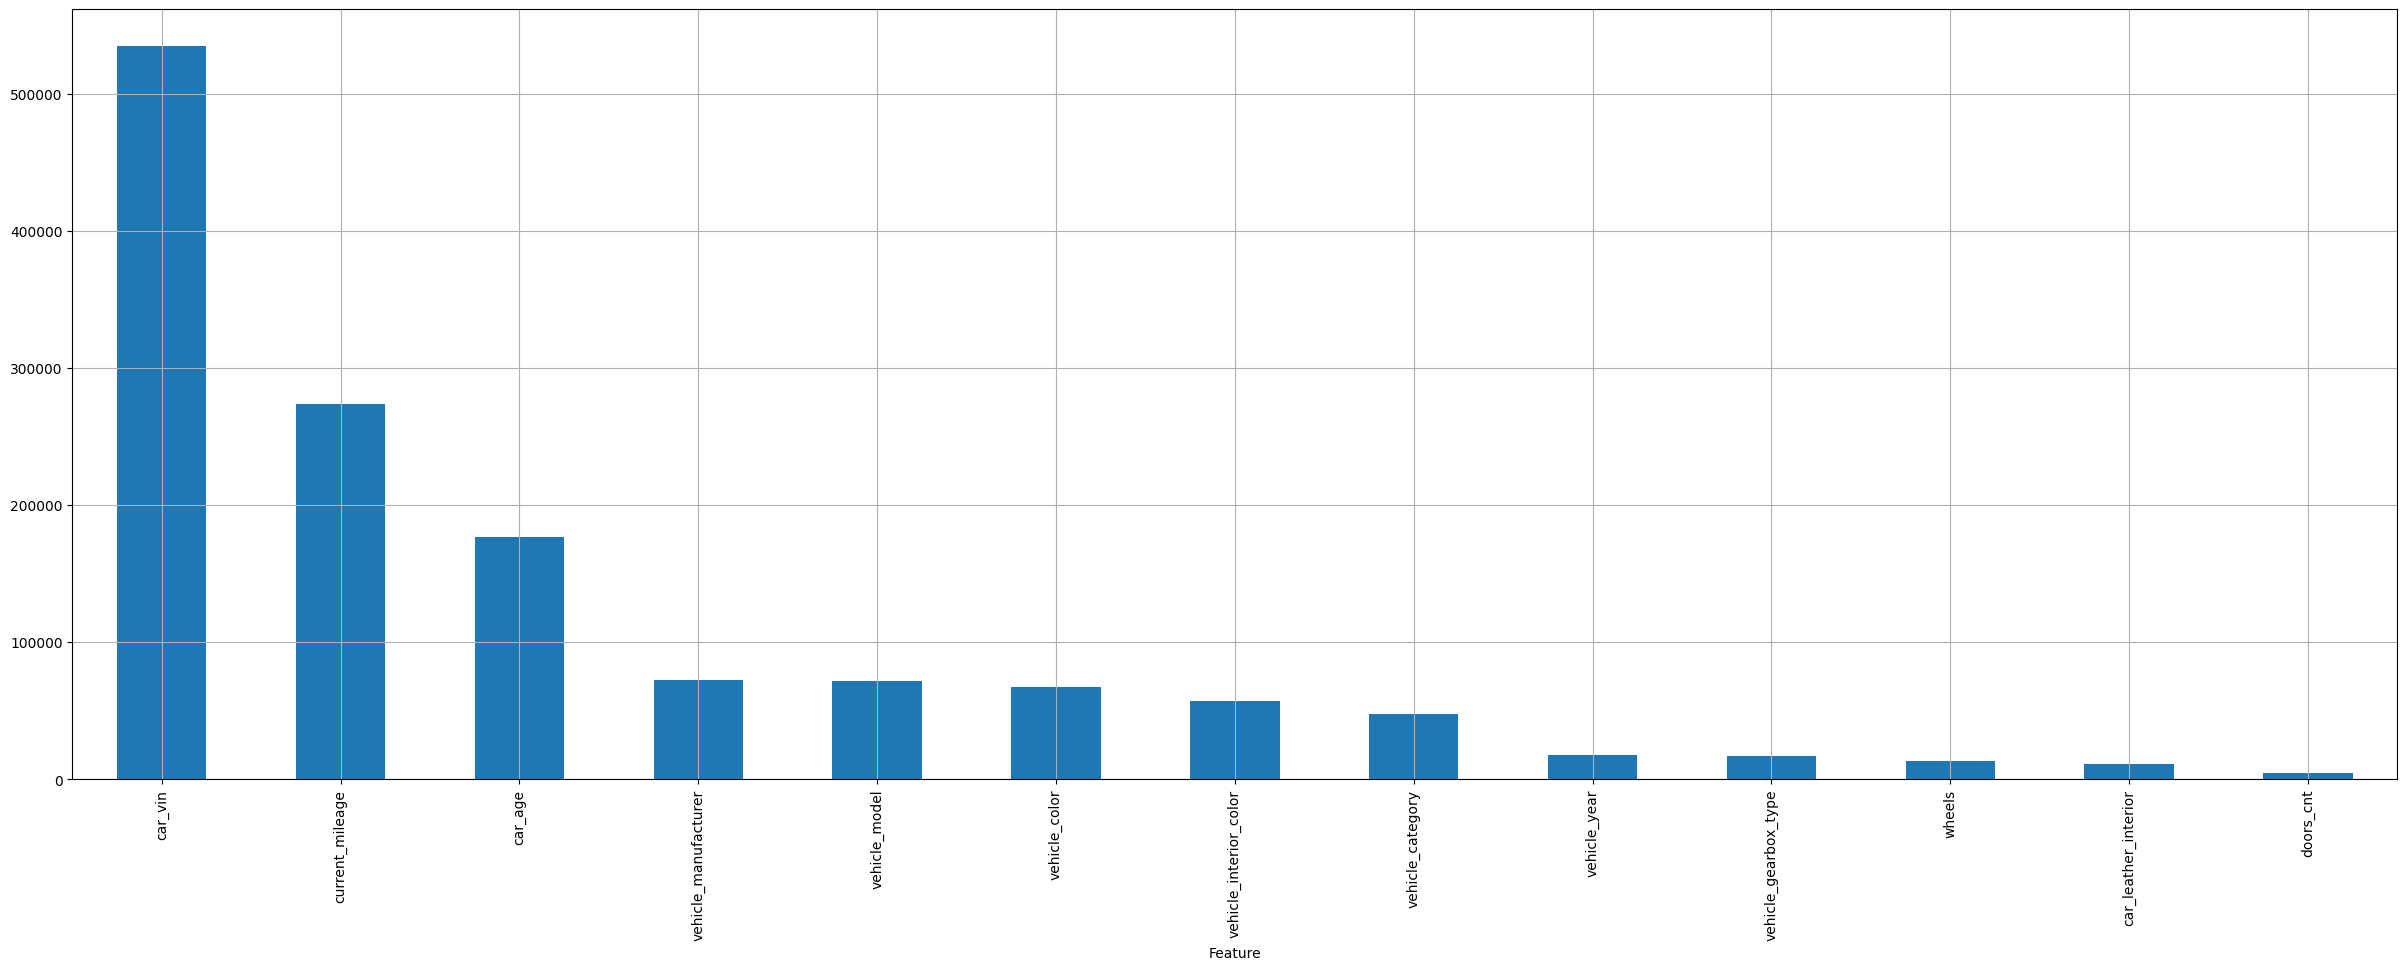

In [170]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [171]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate on bigger datasets
accurate_fi = automl.get_feature_scores('accurate', te_data, silent = False)

CPU times: total: 1min 8s
Wall time: 17.6 s


<AxesSubplot: xlabel='Feature'>

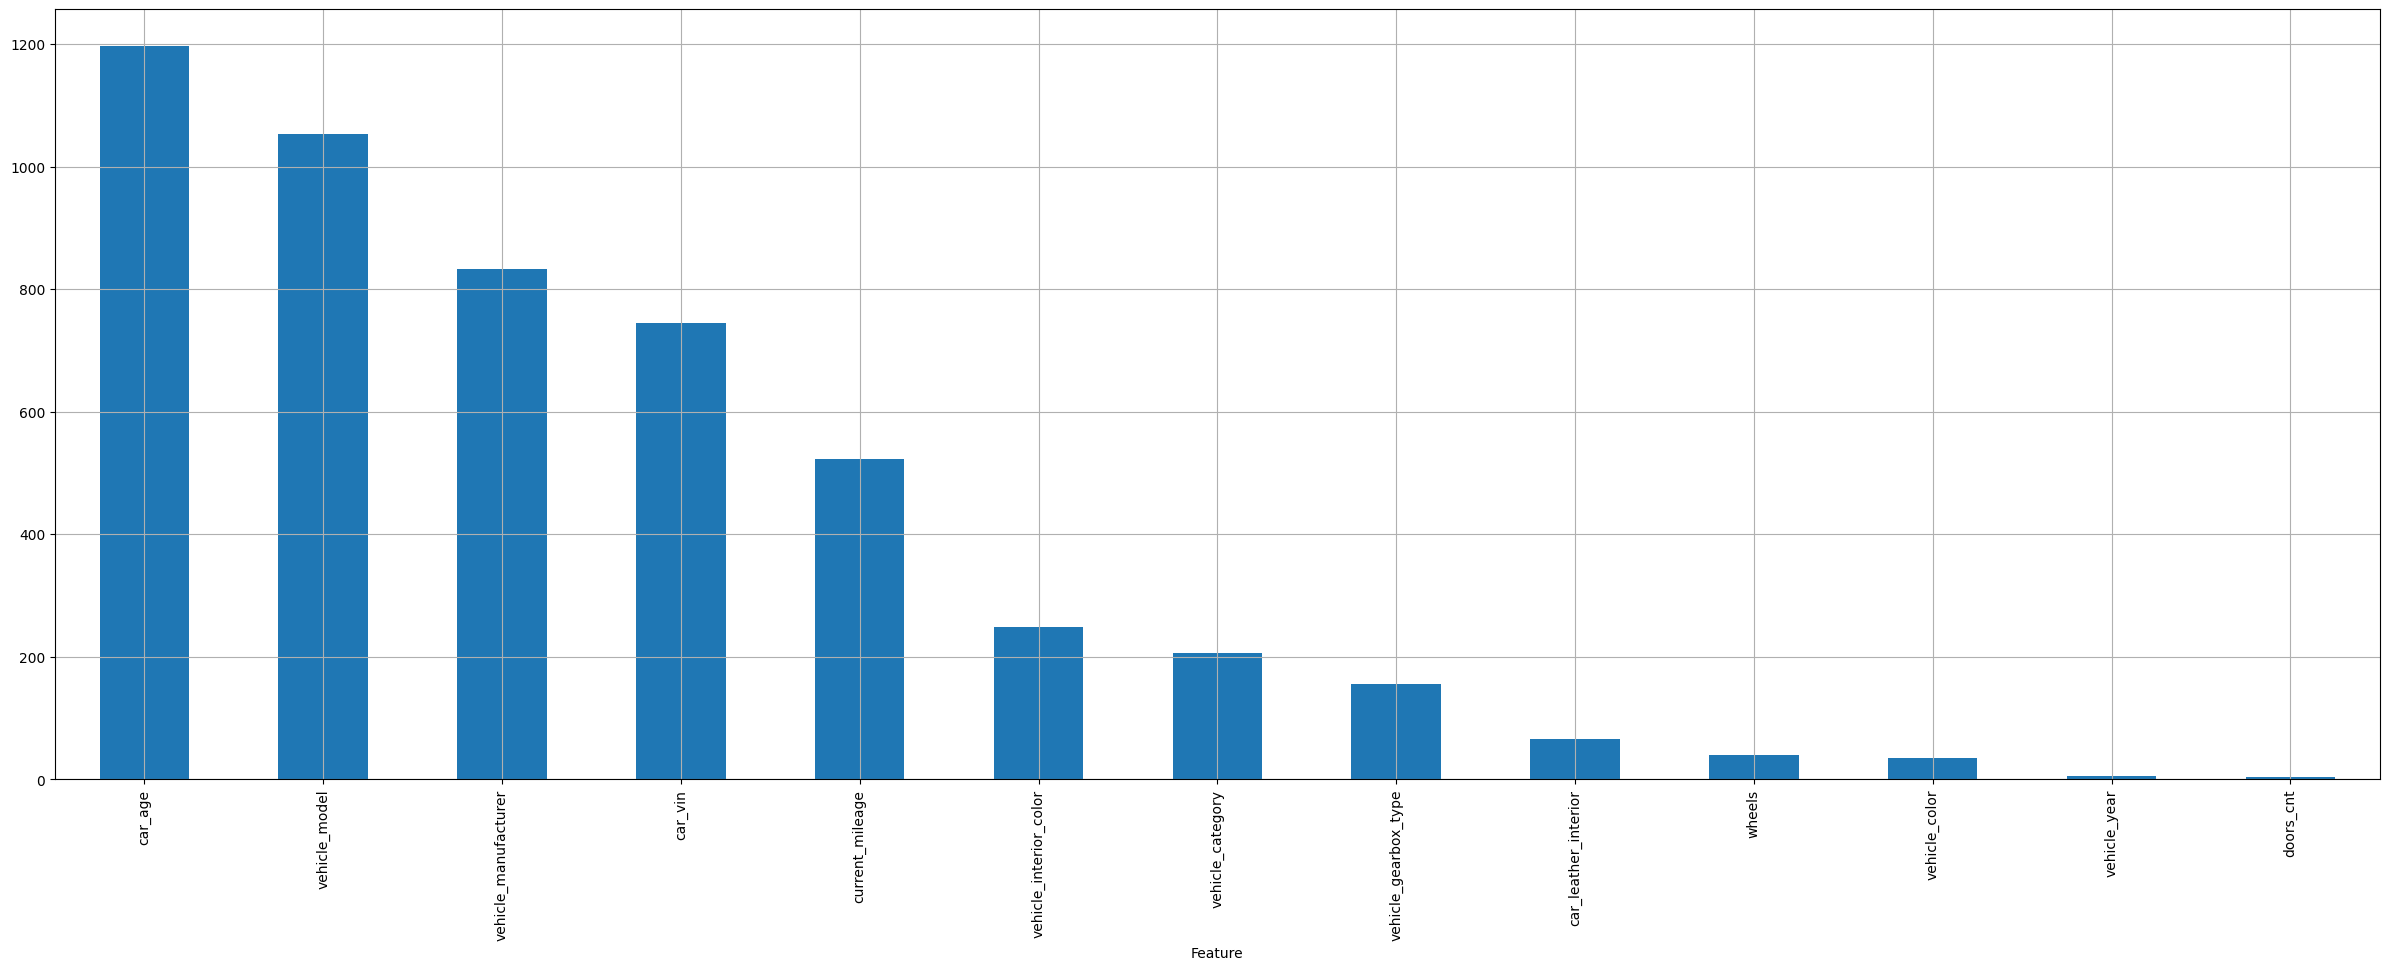

In [172]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# 5. Predict for test dataset

We are also ready to predict for our test competition dataset and submission file creation:

In [173]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

Prediction for te_data:
array([[ 2821.7803],
       [ 5873.693 ],
       [ 6244.7607],
       ...,
       [15748.395 ],
       [ 5001.5825],
       [ 6421.8794]], dtype=float32)
Shape = (10697, 1)


In [174]:
submission[TARGET_NAME] = test_pred.data[:, 0]

submission.loc[test_data_rent_index, 'final_price'] = rent_price

submission.to_csv('lightautoml_tabularautoml.csv', index = False)

# Additional materials

- [Official LightAutoML github repo](https://github.com/AILab-MLTools/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)
- [LightAutoML tutorials](https://github.com/AILab-MLTools/LightAutoML/tree/master/examples/tutorials)
- LightAutoML course:
    - [Part 1 - general overview](https://ods.ai/tracks/automl-course-part1) 
    - [Part 2 - LightAutoML specific applications](https://ods.ai/tracks/automl-course-part2)
    - [Part 3 - LightAutoML customization](https://ods.ai/tracks/automl-course-part3)
- [OpenDataScience AutoML benchmark leaderboard](https://ods.ai/competitions/automl-benchmark/leaderboard)

### If you still like the notebook, do not forget to put upvote for the notebook and the ⭐️ for github repo if you like it using the button below - one click for you, great pleasure for us ☺️

### If you miss the [simple baseline notebook](https://www.kaggle.com/code/alexryzhkov/clone-my-notebook) for this competition, please take a look and upvote it as well. 

In [175]:
s = '<iframe src="https://ghbtns.com/github-btn.html?user=sb-ai-lab&repo=LightAutoML&type=star&count=true&size=large" frameborder="0" scrolling="0" width="170" height="30" title="LightAutoML GitHub"></iframe>'
HTML(s)

c:\Users\kot\OneDrive\Documents\GitHub\SkillFactory-DTS\venv\lib\site-packages\IPython\core\display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
